In [40]:
import numpy as np
from astropy.table import Table, Column, vstack
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.stats import powerlaw
from scipy import integrate
from scipy.special import gammaln
import time
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf
%matplotlib inline

In [2]:
#Import my own functions:
import bayes
import simdat

Metropolis Hastings Algorithm Overview:
1. Create a function that can generate a large parameter space from which to draw samples. Take out a random value from this space, x' (x' is a vector containing values of the parameters)
2. Draw a random number r, such that 0<r<1
3. Calculate the posterior for those values of the parameters.
4. Compare the values of the posterior at x' to the value of the posterior at the previous step, x (if this is the first step, skip this part?)
5. If pdf(x')/pdf(x) > r: keep x' in your parameter space and move to the next point. otherwise, repeat for previous step value, x.

number of photons observed = 500978
generating photon energies via CDF method
Time to generate photon energies = 0.043301820755 seconds
Fraction of photons that are piled = 0.95958904383


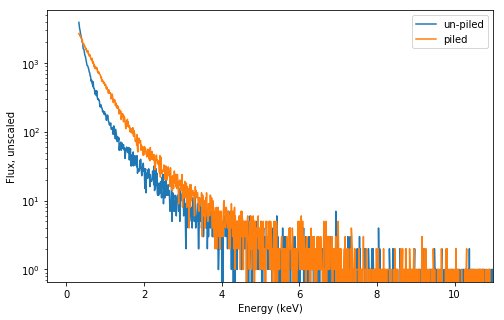

In [3]:
energy,piled_energy = simdat.simulate_data(500000,'cdf')
energy_hist, piled_hist = simdat.plot_data(energy,piled_energy)

In [4]:
arf = Table.read('/Users/mlazz/Dropbox/UW/PileupABC/13858/repro/SDSSJ091449.05+085321.corr.arf',format='fits')
ENERG_LO = np.array(arf['ENERG_LO'])
ENERG_HI = np.array(arf['ENERG_HI'])

In [67]:
#Initially, just do some number of iterations, before worrying about including autocorrelation
def metropolis_hastings(data,E_max,E_min):
    step = 0

    #Run scipy.optimize.minimize on negative log likelihood to get starting values for random walk
    init_params = [np.log(1000000),2.7]
    opt = minimize(bayes.neg_log_likelihood,init_params,args=(data,E_max,E_min),method='Nelder-Mead',options={'disp': False})
    print('Starting values from scipy optimize: logA=',opt.x[0],'alpha=',opt.x[1])
    
    #Generate paramter space for logA and alpha
    size = 10000
    
    #Generate empty arrays for adding chain
    logA_vals = []
    alpha_vals = []
    post_vals = []
    
    #Define number of steps:
    walk_length = 500000
    
    #Take a random walk (in this case, just a finite number of steps)
    while step < walk_length:
        if step == 0:
            logA_vals.append(opt.x[0])
            alpha_vals.append(opt.x[1])
            log_like = bayes.log_likelihood([opt.x[0],opt.x[1]],data,E_max,E_min)
            log_logA_prior = bayes.log_prior_logA(opt.x[0])
            log_a_prior = bayes.log_prior_alpha(opt.x[1])
            running_posterior = bayes.log_posterior(log_like,[log_logA_prior,log_a_prior])
            post_vals.append(running_posterior)
            print('Initial posterior value =',running_posterior)
            
            #Generate parameter space from which to draw next value
            sig_logA = 0.1 #These will need to be chosen more carefully eventually
            sig_a = 0.05 #These will need to be chosen more carefully eventually
            #logA_space = np.random.normal(loc=opt.x[0],scale=sig_logA,size=size)
            #a_space = np.random.normal(loc=opt.x[1],scale=sig_a,size=size)
            step += 1
            
        if step > 0:
            if step%(walk_length/10)==0:
                print('on step',step)
            new_logA = np.random.normal(loc=logA_vals[-1],scale=sig_logA,size=1)
            new_a = np.random.normal(loc=alpha_vals[-1],scale=sig_a,size=1)
            
            log_like = bayes.log_likelihood([new_logA,new_a],data,E_max,E_min)
            log_logA_prior = bayes.log_prior_logA(new_logA)
            log_a_prior = bayes.log_prior_alpha(new_a)
            new_posterior = bayes.log_posterior(log_like,[log_logA_prior,log_a_prior])
            
            r = np.random.uniform(0.0,1.0)
            
            if (new_posterior/running_posterior)>r:
                logA_vals.append(new_logA)
                alpha_vals.append(new_a)
                post_vals.append(new_posterior)
                
                sig_logA = 0.1 #These will need to be chosen more carefully eventually
                sig_a = 0.05 #These will need to be chosen more carefully eventually
                #logA_space = np.random.normal(loc=new_logA,scale=sig_logA,size=size)
                #a_space = np.random.normal(loc=new_a,scale=sig_a,size=size)
                running_posterior = new_posterior
                step += 1
            else:
                continue
    return logA_vals, alpha_vals, post_vals

In [43]:
#Initially, just do some number of iterations, before worrying about including autocorrelation
def metropolis_hastings_acf(data,E_max,E_min):
    correlated = 1
    step = 0
    
    #Run scipy.optimize.minimize on negative log likelihood to get starting values for random walk
    init_params = [np.log(1000000),2.7]
    opt = minimize(bayes.neg_log_likelihood,init_params,args=(data,E_max,E_min),method='Nelder-Mead',options={'disp': False})
    print 'Starting values from scipy optimize: logA=',opt.x[0],'alpha=',opt.x[1]
    
    #Generate paramter space for logA and alpha
    size = 10000
    
    #Generate empty arrays for adding chain
    logA_vals = []
    alpha_vals = []
    post_vals = []
    acf = []
    
    #Define number of steps:
    walk_length = 100000
    
    #Take a random walk (in this case, just a finite number of steps)
    while correlated = 1:
        if step == 0:
            logA_vals.append(opt.x[0])
            alpha_vals.append(opt.x[1])
            log_like = bayes.log_likelihood([opt.x[0],opt.x[1]],data,E_max,E_min)
            log_logA_prior = bayes.log_prior_logA(opt.x[0])
            log_a_prior = bayes.log_prior_alpha(opt.x[1])
            running_posterior = bayes.log_posterior(log_like,[log_logA_prior,log_a_prior])
            post_vals.append(running_posterior)
            print 'Initial posterior value =',running_posterior
            
            #Generate parameter space from which to draw next value
            sig_logA = 0.1 #These will need to be chosen more carefully eventually
            sig_a = 0.1 #These will need to be chosen more carefully eventually
            logA_space = np.random.normal(loc=opt.x[0],scale=sig_logA,size=size)
            a_space = np.random.normal(loc=opt.x[1],scale=sig_a,size=size)
            step += 1
            
        if step > 0:
            if step%(walk_length/10)==0:
                print 'on step',step
            new_logA = logA_space[np.random.randint(0,size)]
            new_a = a_space[np.random.randint(0,size)]
            
            log_like = bayes.log_likelihood([new_logA,new_a],data,E_max,E_min)
            log_logA_prior = bayes.log_prior_logA(new_logA)
            log_a_prior = bayes.log_prior_alpha(new_a)
            new_posterior = bayes.log_posterior(log_like,[log_logA_prior,log_a_prior])
            
            r = np.random.uniform(0.0,1.0)
            
            if (new_posterior/running_posterior)>r:
                logA_vals.append(new_logA)
                alpha_vals.append(new_a)
                post_vals.append(new_posterior)
                
                sig_logA = 0.1 #These will need to be chosen more carefully eventually
                sig_a = 0.1 #These will need to be chosen more carefully eventually
                logA_space = np.random.normal(loc=new_logA,scale=sig_logA,size=size)
                a_space = np.random.normal(loc=new_a,scale=sig_a,size=size)
                running_posterior = new_posterior
                
                #Check ACF:
                
                
                step += 1
            else:
                continue
    return np.array(logA_vals), np.array(alpha_vals), np.array(post_vals)

SyntaxError: invalid syntax (<ipython-input-43-03a5cf6215c8>, line 23)

In [51]:
def estimated_autocorrelation(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))
    return result


In [59]:
def converged(x):
    acf = autocorr(x)
    end_chain =acf[np.int(0.8*len(acf)):len(acf)-1]
    diff = np.fabs(end_chain - np.mean(end_chain))
    if np.mean(diff)<0.1:
        return True
    else:
        return False

In [60]:
converged(np.array(logA))

False

In [71]:
acf = estimated_autocorrelation(np.array(logA))

KeyboardInterrupt: 

In [74]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]
acf = autocorr(np.array(logA))

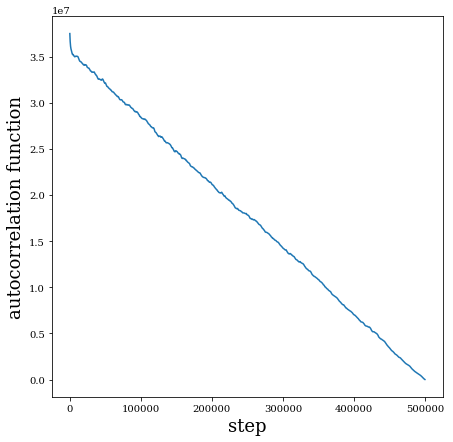

In [75]:
fig,ax = plt.subplots(figsize=(7,7))
ax.plot(np.arange(0,len(logA),1),acf)
ax.set_xlabel('step',fontsize=18)
ax.set_ylabel('autocorrelation function',fontsize=18)

In [68]:
logA,alpha,posteriors=metropolis_hastings(energy_hist,ENERG_HI,ENERG_LO)
logA_piled,alpha_piled,posteriors_piled=metropolis_hastings(piled_hist,ENERG_HI,ENERG_LO)

Starting values from scipy optimize: logA= 9.7461594902 alpha= 2.69390499038
Initial posterior value = 840365.110383
on step 50000
on step 100000
on step 150000
on step 200000
on step 250000
on step 300000
on step 350000
on step 400000
on step 450000
Starting values from scipy optimize: logA= 10.3822305365 alpha= 2.23238906282
Initial posterior value = 1251965.40702
on step 50000
on step 100000
on step 150000
on step 200000
on step 250000
on step 300000
on step 350000
on step 400000
on step 450000


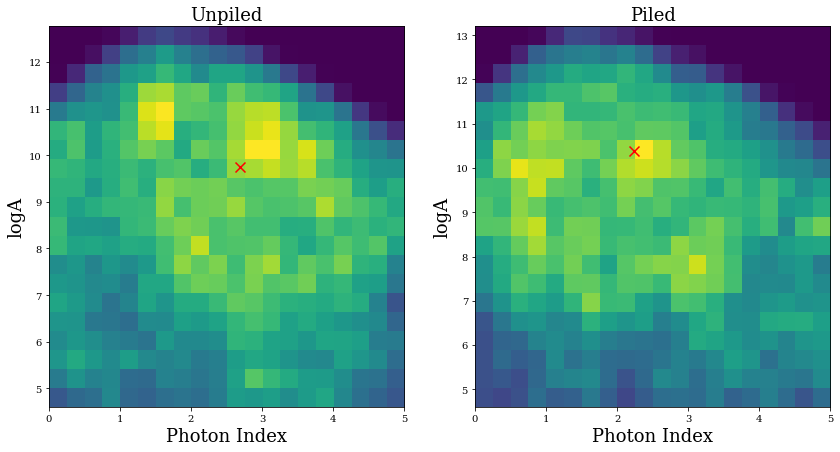

In [69]:
plt.rc('font', family='serif')
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(14,7))
ax[0].hist2d(alpha,logA,bins=[20,20])
ax[0].scatter(2.69390499038,9.7461594902,marker='x',color='r',s=100)
ax[0].set_xlabel('Photon Index',fontsize=18)
ax[0].set_ylabel('logA',fontsize=18)
ax[0].set_title('Unpiled',fontsize=18)

ax[1].hist2d(alpha_piled,logA_piled,bins=[20,20])
ax[1].scatter(2.23238906282,10.3822305365,marker='x',color='r',s=100)
ax[1].set_xlabel('Photon Index',fontsize=18)
ax[1].set_ylabel('logA',fontsize=18)
ax[1].set_title('Piled',fontsize=18)

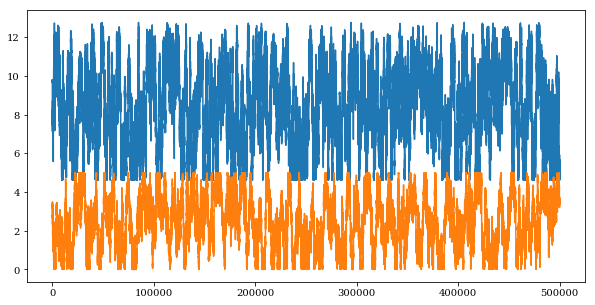

In [70]:
iteration = np.arange(0,len(logA),1)
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(iteration,logA)
ax.plot(iteration,alpha)

(100000, 2)


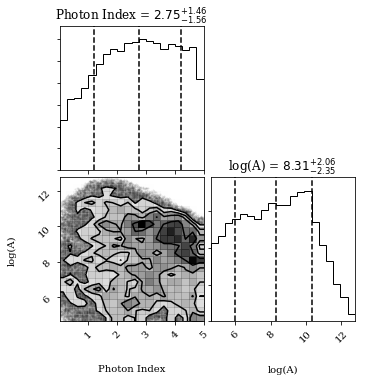

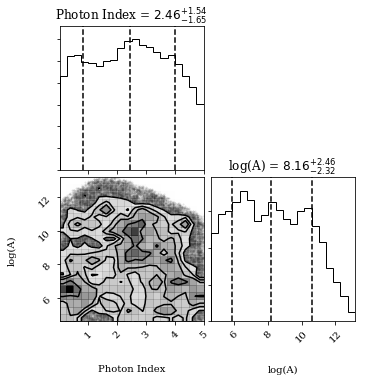

In [34]:
import corner

data = np.vstack((alpha,logA)).T
data_piled = np.vstack((alpha_piled,logA_piled)).T
print np.shape(data)

# Plot it.
#fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(14,7))
figure1 = corner.corner(data, labels=["Photon Index", "log(A)"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})
figure2 = corner.corner(data_piled, labels=["Photon Index", "log(A)"],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})